In [7]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('./src')
from geometry import *
from tubes import closed_geometry
from solver import stokes2d
from joblib import Parallel, delayed

In [8]:
p1 = np.array([-5,-1])
curve1 = line

p2 = np.array([-1,-1])
curve2 = line

p3 = np.array([-1,-5])
curve3 = cap

p4 = np.array([1,-5])
curve4 = line

p5 = np.array([1,1])
curve5 = line

p6 = np.array([-5,1])
curve6 = cap

In [9]:
pts = [p1, p2, p3, p4, p5, p6]
curves = [curve1, curve2, curve3, curve4, curve5, curve6]

In [4]:
band = closed_geometry(pts,curves,corner_size=0.5)
band.build_geometry(max_distance=0.01)

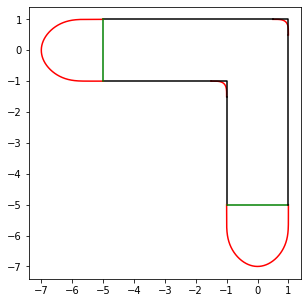

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect(1)

for i in band.curves:
    if isinstance(i,line):
        ax.plot(i.x,i.y,c='black')
    if isinstance(i,cap):
        ax.plot(i.x,i.y,c='red')
        ax.plot([i.p1[0],i.p2[0]],[i.p1[1],i.p2[1]],c='green')
    if isinstance(i,corner):
        ax.plot(i.x,i.y,c='red')
        pts = np.array((i.p1,i.p_,i.p2)).T
        ax.plot(pts[0],pts[1],c='black')
        


# solvers, pressure drops, velocity field

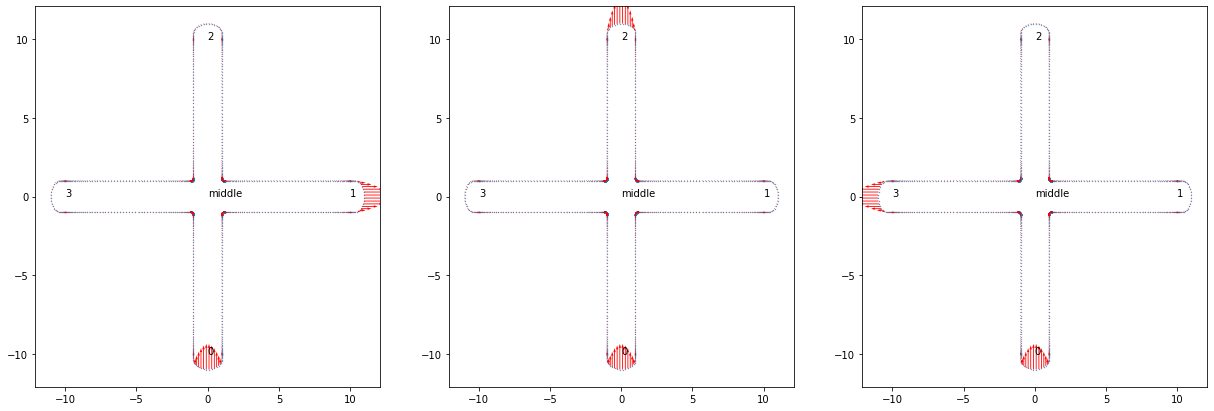

In [8]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    for k,j in enumerate(cross.caps):
        axes[i].text(cross.curves[j].p[0],cross.curves[j].p[1],str(k))
    axes[i].text(0,0,'middle')
    

In [9]:
solver = stokes2d(cross,gmres_tol=1e-12)
solver.build_A_fmm()
solver.build_A()

In [10]:
# omegas = [solver.compute_omega(flows_boundary_condition,if_fmm=True) for flows_boundary_condition in flows_boundary_conditions]
omegas_fmm_with_callback = Parallel(n_jobs=4)(delayed(solver.compute_omega)(flows_boundary_condition,if_fmm=True,if_callback=True, if_lgmres=False) for flows_boundary_condition in flows_boundary_conditions)
omegas_fmm = [i for i,_ in omegas_fmm_with_callback]
fmm_callback = [i for _,i in omegas_fmm_with_callback]

/home/haiy/pkg/miniconda3/envs/bim/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/haiy/pkg/miniconda3/envs/bim/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/haiy/pkg/miniconda3/envs/bim/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


gmres did not converge after 100  iterations
gmres did not converge after 100  iterations
gmres did not converge after 100  iterations


In [11]:
omegas_dir_with_callback = Parallel(n_jobs=4)(delayed(solver.compute_omega)(flows_boundary_condition,if_fmm=False,if_callback=True) for flows_boundary_condition in flows_boundary_conditions)
omegas_dir = [i for i,_ in omegas_dir_with_callback]
dir_callback = [i for _,i in omegas_dir_with_callback]

/home/haiy/pkg/miniconda3/envs/bim/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## gmres analysis

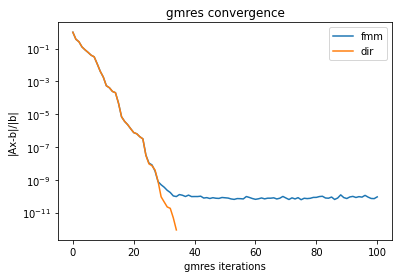

In [16]:
plt.semilogy(range(fmm_callback[0].counter),fmm_callback[0].norm,label='fmm')
plt.semilogy(range(dir_callback[0].counter),dir_callback[0].norm,label='dir')
plt.title('gmres convergence')
plt.xlabel('gmres iterations')
plt.ylabel('|Ax-b|/|b|')
plt.legend()

In [26]:
pressure_drops = []
    
for i,flow in enumerate(flows):
    # computing the pressure drop with unit flux of the flow i. 
    omega = omegas[i]
    pressure_drop = []

    start_point = cross.curves[inflow].p
    start_point_z = start_point[0] + 1j*start_point[1]
    start_point_pressure = solver.compute_pressure(start_point_z,omega)
    
    for j,flow2 in enumerate(flows):
        # integrating the pressure drop in the flow j. 
        end_point = cross.curves[flow2[1]].p
        end_point_z = end_point[0] + 1j*end_point[1]
        pressure_drop.append(solver.compute_pressure(end_point_z,omega)-start_point_pressure)
        
    pressure_drops.append(pressure_drop)

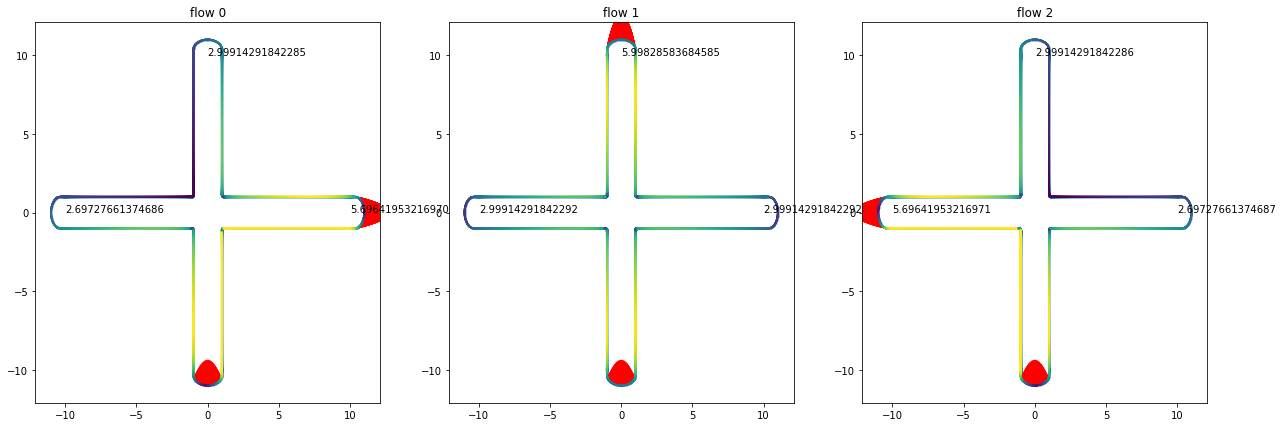

In [30]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    axes[i].title.set_text('flow '+str(i))
    
    for j in range(3):
        out = flows[j][1]
        end_point = cross.curves[out].p
        axes[i].text(end_point[0],end_point[1], f'{pressure_drops[i][j]:.14f}')
        
    axes[i].scatter(cross.x,cross.y,s=1,c=np.abs(omegas[i]),vmin=0,vmax=10)


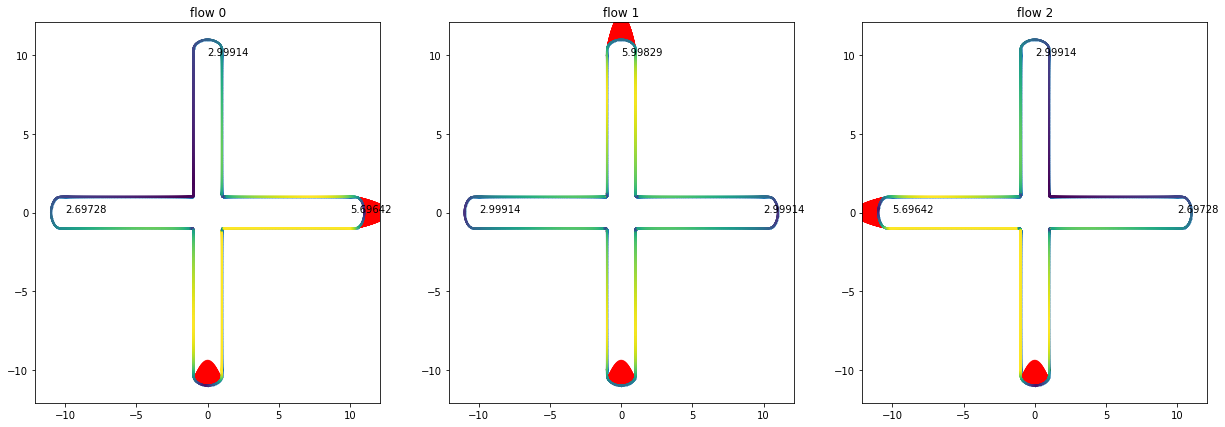

In [31]:
fig, axes = plt.subplots(1,3, figsize=(21,7))
for i in range(3):
    axes[i].scatter(cross.x,cross.y,s=0.1)
    axes[i].quiver(cross.x,cross.y,flows_boundary_conditions[i][:,0],flows_boundary_conditions[i][:,1],scale=10,color='r')
    axes[i].title.set_text('flow '+str(i))
    
    for j in range(3):
        out = flows[j][1]
        end_point = cross.curves[out].p
        axes[i].text(end_point[0],end_point[1], f'{pressure_drops[i][j]:.5f}')
        
    axes[i].scatter(cross.x,cross.y,s=1,c=np.abs(omegas[i]),vmin=0,vmax=10)
